In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path_images = [
    "../images/ex01.jpg",
    "../images/ex02.jpg",
    "../images/abstract_ex01.jpg",
    "../images/abstract_ex02.jpg",
    "../images/abstract_ex03.jpg",
]

In [18]:
def segment(image, color):
    
    ###################################################
    # 1) Here are defined structuring elements that are going to be used through all this code
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    kernel3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))

    reach = 19
    thickness = 3

    kernel_plus = cv2.getStructuringElement(cv2.MORPH_CROSS, (reach,reach))
    kernel_plusthick = cv2.morphologyEx(kernel_plus, cv2.MORPH_DILATE, kernel2, iterations = thickness)
    kernel_x = ((np.diag(np.ones(reach, dtype = int)) + np.diag(np.ones(reach, dtype = int))[::-1]) > 0).astype(np.uint8)
    kernel_xthick = cv2.morphologyEx(kernel_x, cv2.MORPH_DILATE, kernel2, iterations = thickness)
    
    ###################################################
    
    
    ###################################################
    # 2) Adaptative threshold applied to the grayscale image
    blur = cv2.medianBlur(image, 7)
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,31, 3)
    thresh = 255 - thresh
    ###################################################

    
    ###################################################
    # 3) Image is converted to hsv and the especific HUE is selected
    hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV).astype(int)
    if color == "blue":
        lower = np.array([90, 0, 0]) 
        upper = np.array([150, 255, 255])
        hsv_filtered = cv2.inRange(hsv, lower, upper)
    else:
        rotate = 10
        lower = np.array([140 - rotate, 0, 0]) 
        upper = np.array([255, 255, 255])
        hsv_filtered = cv2.inRange((hsv - rotate) % 255, lower, upper)
    ###################################################
    
    
    ###################################################
    # 4) Grayscale threshold and filtered HUE are combined into the same mask
    combined = cv2.bitwise_and(thresh, hsv_filtered)   
    combined = cv2.morphologyEx(combined, cv2.MORPH_DILATE, kernel, iterations = 2)
    ###################################################

    
    ###################################################
    # 5) Contours are detected. Contours that are too small are removed
    _, cnts, hierarchy = cv2.findContours(combined, cv2.CHAIN_APPROX_SIMPLE, cv2.CHAIN_APPROX_SIMPLE)
    MASK = np.zeros_like(gray, dtype = np.uint8)
    min_area = 10 ** 5
    for c in cnts:
        area = cv2.contourArea(c)

        xs = np.array(c).ravel()[::2]
        ys = np.array(c).ravel()[1::2]
        longest = max(xs.max() - xs.min(), ys.max() - ys.min())

        if longest > 150:
            # should verify here if figure has large area, if it has then, it is a block already
            cv2.drawContours(MASK,[c], 0, (255, 255, 255), -1)
            continue
    ###################################################
    
    ###################################################
    # 6) Final contours are better connected with Close operation
    MASK = cv2.morphologyEx(MASK, cv2.MORPH_CLOSE, kernel_plusthick, iterations = 1)
    MASK = cv2.morphologyEx(MASK, cv2.MORPH_CLOSE, kernel_xthick, iterations = 1)
    MASK = cv2.morphologyEx(MASK, cv2.MORPH_CLOSE, kernel3, iterations = 1)
    ###################################################
    
    
    ###################################################
    # 7) Only contours that are big enough are kept
    # 8) A polygon is fitted around the remaining contours
    _, cnts, hierarchy = cv2.findContours(MASK, cv2.CHAIN_APPROX_SIMPLE, cv2.CHAIN_APPROX_SIMPLE)
    MASK = np.zeros_like(gray, dtype = np.uint8)
    FINAL = np.zeros_like(gray, dtype = np.uint8)
    for c in cnts:
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        box_area = cv2.contourArea(box)
        if box_area > 10**5: # test should be proportion perimeter vs area
            # if want to see what is left from the image before:
            cv2.drawContours(MASK,[c], 0, (255, 255, 255), -1)
            hull = cv2.convexHull(c)
            # lazy approach to finish
            cv2.drawContours(FINAL,[hull], 0, (255, 255, 255), -1)
#             cv2.drawContours(FINAL,[box], 0, (255, 255, 255), -1)
    ###################################################
    
    ###################################################
    # 9) HoughTransform try to better connect contours
    UNKN = combined.copy()
    minLineLength = 1
    maxLineGap = 0
    lines = cv2.HoughLinesP(combined,cv2.HOUGH_PROBABILISTIC, np.pi/360, 10, minLineLength,maxLineGap)
    lines = lines if type(lines) != type(None) else []
    for x in range(0, len(lines)):
        for x1,y1,x2,y2 in lines[x]:
            #cv2.line(inputImage,(x1,y1),(x2,y2),(0,128,0),2, cv2.LINE_AA)
            pts = np.array([[x1, y1 ], [x2 , y2]], np.int32)
            d = (pts[1] - pts[0]) 
#             if np.linalg.norm(d) > 20:
#                 continue
            d = d * 1 # Escalar com a imagem!! Pegue uma proporção da figura
            pts = np.array([pts[0] - d, pts[1] + d], np.int32)
            cv2.polylines(UNKN, [pts], True, (255,255,255), 1)
            
    FINAL = np.zeros_like(gray, dtype = np.uint8)
    _, cnts, hierarchy = cv2.findContours(UNKN, cv2.CHAIN_APPROX_SIMPLE, cv2.CHAIN_APPROX_SIMPLE)
    for c in cnts:
        box_area = cv2.contourArea(c)
        if box_area > 10**5: # test should be proportion perimeter vs area
            cv2.drawContours(FINAL,[c], 0, (255, 255, 255), -1)
            
    ###################################################

    

    plt.figure(figsize=(16, 8))
    i = 0
    
    i+=1
    plt.subplot(1,4,i)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(inputImage, cv2.COLOR_BGR2RGB))
    
    i+=1
    plt.subplot(1,4,i)
    plt.title("Cobination with Closing")
    plt.imshow(combined)
    
    i+=1
    plt.subplot(1,4,i)
    plt.title("HoughTransform - extended lines")
    plt.imshow(UNKN)
    
    i+=1
    plt.subplot(1,4,i)
    plt.title("Filled regions")
    plt.imshow(FINAL)
    
    plt.tight_layout()

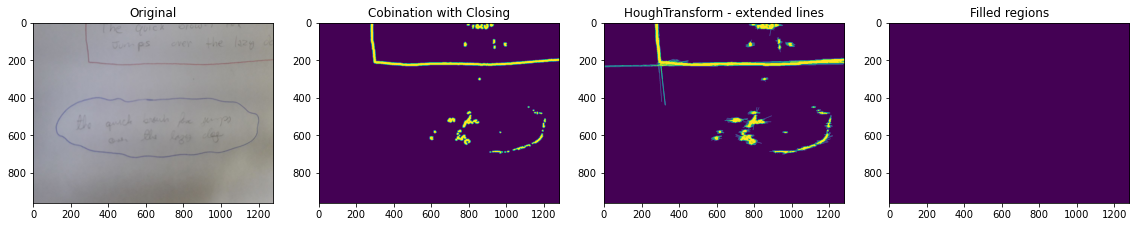

####################################################################################################


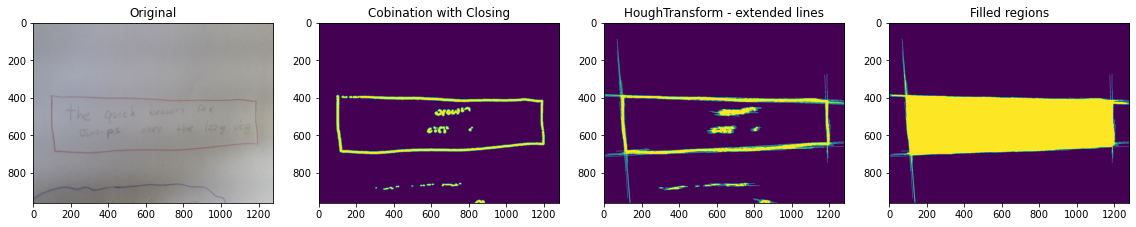

####################################################################################################


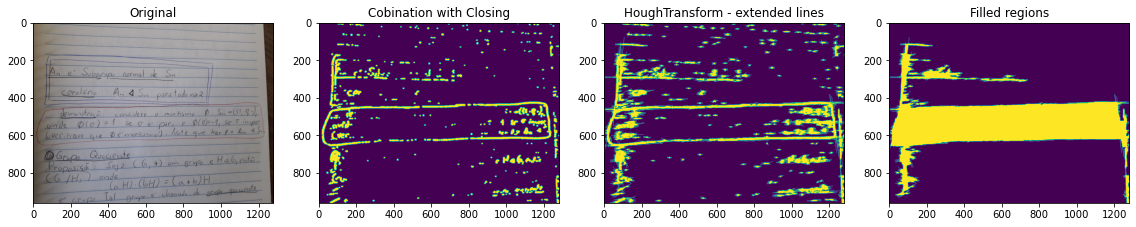

####################################################################################################


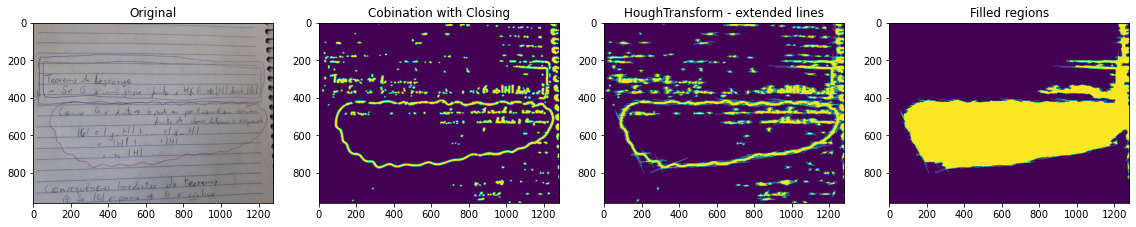

####################################################################################################


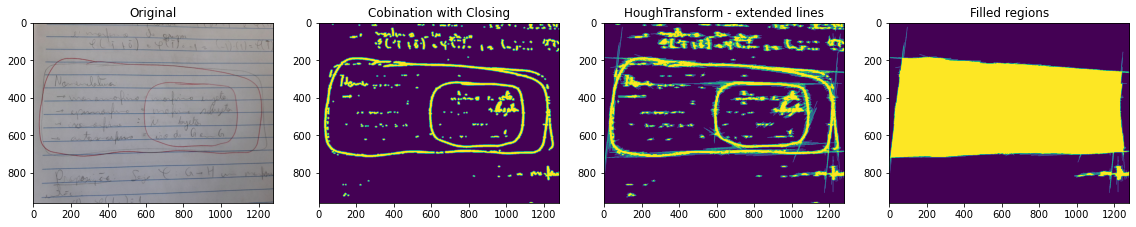

####################################################################################################


In [19]:
color = "red"
for image_path in path_images:
    inputImage = cv2.imread(image_path)
    segment(inputImage, color)
    plt.show()
    print("#" * 100)

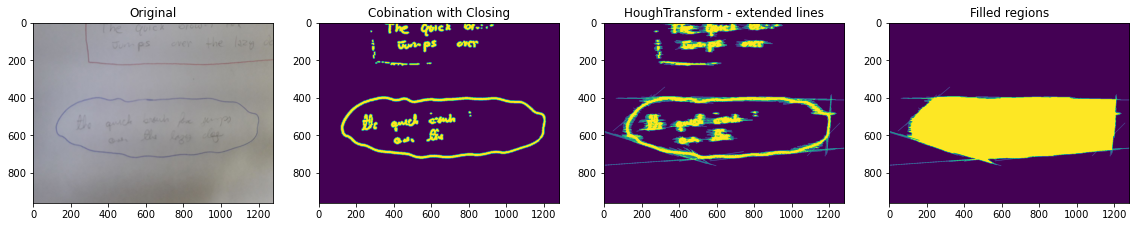

####################################################################################################


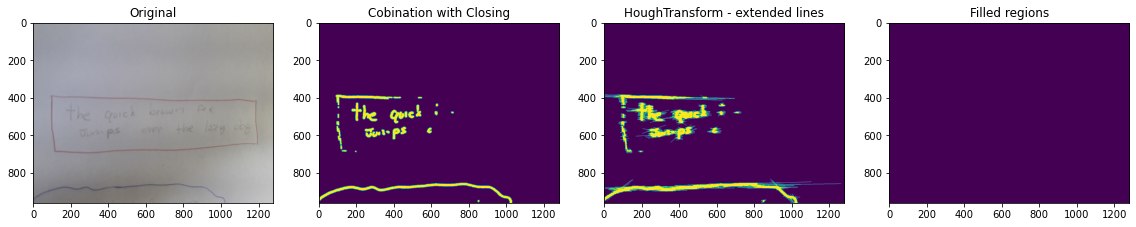

####################################################################################################


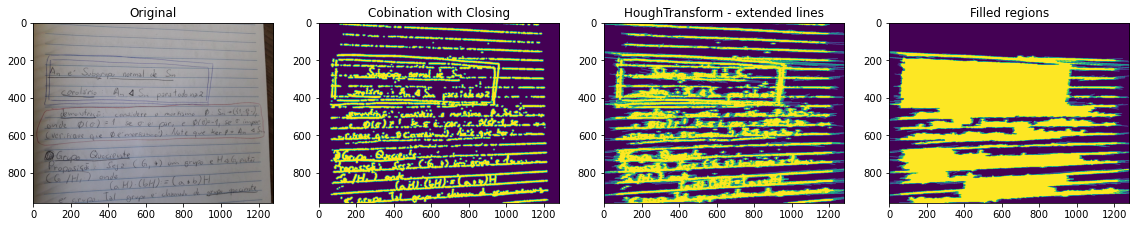

####################################################################################################


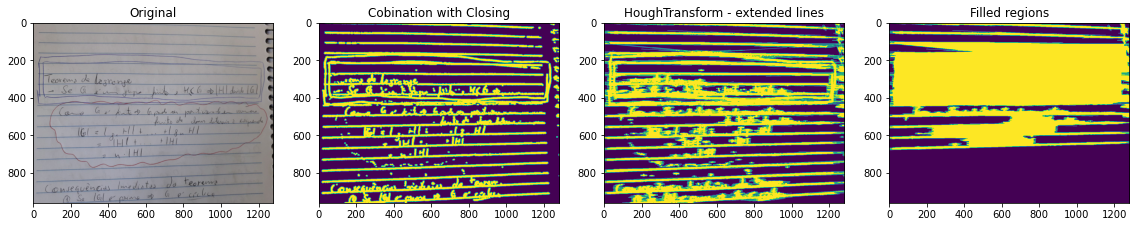

####################################################################################################


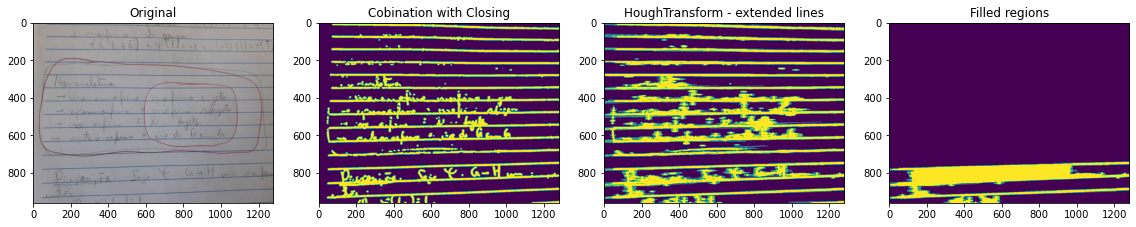

####################################################################################################


In [20]:
color = "blue"
for image_path in path_images:
    inputImage = cv2.imread(image_path)
    segment(inputImage, color)
    plt.show()
    print("#" * 100)